## Preparation

In [1]:
import pandas as pd
%pylab inline
from datetime import datetime

# date handling
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')

Populating the interactive namespace from numpy and matplotlib


## Read Data

In [2]:
abo_canc = pd.read_csv("../data/SSOID_CancDatum.CSV", encoding = 'latin-1', 
                       date_parser = dateparse, parse_dates=["K Tag"])
user_behaviour = pd.read_csv('../data/SSO ID Promo PI Visits nach Monat.csv',sep=';',header=3,
                             engine='python',skipfooter=1, dtype={'AN Promotion ID':np.int32})
product_owner = pd.read_csv("../data/SSOID_Produktbesitze.CSV", encoding = 'latin-1', 
                            parse_dates = ['VB_Tag','VE_Tag'], date_parser = dateparse,
                           dtype={'Promotion ID':np.int32})


### Some Merging and Data filtering

In [3]:
## merge of product_owner with user_behaviour and abo_canc, keep all product owner entries

# only customers with VollAbo and WeltPlus etc.
product_owner_WeltPlus = product_owner.loc[(product_owner['Promotion_ID']==10003002) | 
                         (product_owner['Promotion_ID']==10003006) |
                         (product_owner['Promotion_ID']==10003011)  ].copy()
product_owner_Vollabo = product_owner_WeltPlus.loc[product_owner_WeltPlus['Vertragsphase'] == 'Vollabo'].copy()

# left merge (=keep information from all SSO-IDs in product_owner) with user_behaviour
product_owner_w_usrBehav = pd.merge(product_owner_Vollabo, user_behaviour, how = 'left',
                              left_on=['KD SSO-ID', 'Promotion_ID'] ,right_on=['KD SSO-ID','AN Promotion ID'])

# clean abo_canc = only subscrptions from WeltPlus etc.
abo_canc_WeltPlus = abo_canc.loc[ (abo_canc['AN Promotion ID']==10003002) |
                            (abo_canc['AN Promotion ID']==10003006) |
                            (abo_canc['AN Promotion ID']==100030011)].copy()

# find last subscritpions in ab_canc which more than one K Tag, drop entries with first K Tag
abo_canc_WeltPlus.sort_values('K Tag', inplace=True)
abo_canc_WeltPlus = abo_canc_WeltPlus.drop_duplicates('KD SSO-ID', keep='last')

# left merge (=keep information from all SSO-IDs in product_owner) with abo_canc
product_owner_w_usrBehav = pd.merge(product_owner_w_usrBehav, abo_canc_WeltPlus, how = 'left',
                              left_on=['KD SSO-ID', 'Promotion_ID'] ,right_on=['KD SSO-ID','AN Promotion ID'])

# Verändert sich das Nutzerverhalten (Intensivität der Nutzung) vorm Kündigen?

## Building a Data Frame

Data Frame will consist of SSO-ID of users with VollAbo of WeltPlus, WeltPremium and WeltGold, date of subscription beginnning, if applicable cancellation date, and different metrics of user behavior 3 month before before cancellation.

In [4]:
# function which finds user behaviour before cancellation, if there is no cancellation return last months
def find_user_behaviour_before_canc(dat):
  
    # if there is no cancellation just use user behaviour of last three months
    if pd.isnull(dat['K Tag']):
        # page impressions
        dat['3_pi'] = dat['2018/03']
        dat['2_pi'] = dat['2018/02']
        dat['1_pi'] = dat['2018/01']
        
        # visits
        dat['3_v'] = dat['2018/03.1']
        dat['2_v'] = dat['2018/02.1']
        dat['1_v'] = dat['2018/01.1']

    else:
        # cancellaton date is too early, there is not enough information on user behaviour
        # --> setting values to Na
        if (dat['K Tag'].month < 2) & (dat['K Tag'].year == 2017):

            # page impressions
            dat['1_pi'] = NaN
            dat['2_pi'] = NaN
            dat['3_pi'] = NaN

            # visits
            dat['1_v'] = NaN
            dat['2_v'] = NaN
            dat['3_v'] = NaN
            
        
        else:
            # there is no user behaviour for April 2018 -> setting cancellation day to March 2018
            if (dat['K Tag'].month == 4) & (dat['K Tag'].year == 2018):
                canc_day = pd.Timestamp(datetime(2018, 3, 30))
            
            # there is a cancellation date in expected time frame 
            else:
                canc_day = dat['K Tag']
            
            # date series of last three months before cancellation date
            p = pd.PeriodIndex(freq='m', end=canc_day, periods=3)
            
            # construct correct column index from date series
            # page impressions
            dat['1_pi'] = dat[ str(p[0].year)+'/'+str(p[0].month).zfill(2) ]
            dat['2_pi'] = dat[ str(p[1].year)+'/'+str(p[1].month).zfill(2) ]
            dat['3_pi'] = dat[ str(p[2].year)+'/'+str(p[2].month).zfill(2) ]

            # visits
            dat['1_v'] = dat[ str(p[0].year)+'/'+str(p[0].month).zfill(2) + '.1' ]
            dat['2_v'] = dat[ str(p[1].year)+'/'+str(p[1].month).zfill(2) + '.1' ]
            dat['3_v'] = dat[ str(p[2].year)+'/'+str(p[2].month).zfill(2) + '.1' ]
    return(dat)

In [5]:
# construct data frame w empty columns
product_owner_w_lastUserBehav = product_owner_w_usrBehav.copy()
product_owner_w_lastUserBehav['1_pi'] = np.nan
product_owner_w_lastUserBehav['2_pi'] = np.nan
product_owner_w_lastUserBehav['3_pi'] = np.nan
product_owner_w_lastUserBehav['1_v'] = np.nan
product_owner_w_lastUserBehav['2_v'] = np.nan
product_owner_w_lastUserBehav['3_v'] = np.nan
# call function
product_owner_w_lastUserBehav = product_owner_w_usrBehav.apply(func=find_user_behaviour_before_canc, axis=1)

In [6]:
# construct pi per v for each month
product_owner_w_lastUserBehav['1_pi_per_v'] = product_owner_w_lastUserBehav['1_pi'].divide(product_owner_w_lastUserBehav['1_v'])
product_owner_w_lastUserBehav['2_pi_per_v'] = product_owner_w_lastUserBehav['2_pi'].divide(product_owner_w_lastUserBehav['2_v'])
product_owner_w_lastUserBehav['3_pi_per_v'] = product_owner_w_lastUserBehav['3_pi'].divide(product_owner_w_lastUserBehav['3_v'])

## Untersuchung vom Nutzerverhalten vorm Kündigen

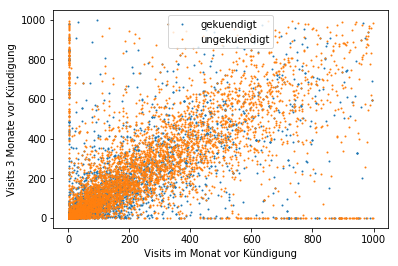

In [7]:
groups = product_owner_w_lastUserBehav.groupby('Kuendigungsstatus')

fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['1_v'], group['3_v'], marker='o', linestyle='', ms=1, label=name)
ax.legend()
ax.set_xlabel("Visits im Monat vor Kündigung")
ax.set_ylabel("Visits 3 Monate vor Kündigung")

plt.show()

In [8]:
print('Korrelation von Page Impressions zwischen Monat vor Kündigung und 2 Monate vor Kündigung:')
print('gekündigt: ',groups[['1_pi','3_pi']].corr().iloc[1,0])
print('ungekündigt: ',groups[['1_pi','3_pi']].corr().iloc[3,0])
print('Korrelation von Page Impressions zwischen 1 Monat vor Kündigung und 2 Monate vor Kündigung:')
print('gekündigt: ',groups[['1_pi','2_pi']].corr().iloc[1,0])
print('ungekündigt: ',groups[['1_pi','2_pi']].corr().iloc[3,0])
print('Korrelation von Page Impressions zwischen 1 Monat vor Kündigung und 2 Monate vor Kündigung:')
print('gekündigt: ',groups[['3_pi','2_pi']].corr().iloc[1,0])
print('ungekündigt: ',groups[['3_pi','2_pi']].corr().iloc[3,0])
print('')
print('Korrelation von Visits zwischen Monat vor Kündigung und 2 Monate vor Kündigung:')
print('gekündigt: ',groups[['1_v','3_v']].corr().iloc[1,0])
print('ungekündigt: ',groups[['1_v','3_v']].corr().iloc[3,0])
print('Korrelation von Visits zwischen 1 Monat vor Kündigung und 2 Monate vor Kündigung:')
print('gekündigt: ',groups[['1_v','2_v']].corr().iloc[1,0])
print('ungekündigt: ',groups[['1_v','2_v']].corr().iloc[3,0])
print('')
print('Korrelation von PI per V zwischen Monat vor Kündigung und 2 Monate vor Kündigung:')
print('gekündigt: ',groups[['1_pi_per_v','3_pi_per_v']].corr().iloc[1,0])
print('ungekündigt: ',groups[['1_pi_per_v','3_pi_per_v']].corr().iloc[3,0])
print('Korrelation von PI per V zwischen Monat vor Kündigung und 2 Monate vor Kündigung:')
print('gekündigt: ',groups[['1_pi_per_v','2_pi_per_v']].corr().iloc[1,0])
print('ungekündigt: ',groups[['1_pi_per_v','2_pi_per_v']].corr().iloc[3,0])

Korrelation von Page Impressions zwischen Monat vor Kündigung und 2 Monate vor Kündigung:
gekündigt:  0.8202295349073246
ungekündigt:  0.8430775589209465
Korrelation von Page Impressions zwischen 1 Monat vor Kündigung und 2 Monate vor Kündigung:
gekündigt:  0.877619444173298
ungekündigt:  0.889108445303199
Korrelation von Page Impressions zwischen 1 Monat vor Kündigung und 2 Monate vor Kündigung:
gekündigt:  0.8570934433732311
ungekündigt:  0.8859691620751899

Korrelation von Visits zwischen Monat vor Kündigung und 2 Monate vor Kündigung:
gekündigt:  0.6296495650198096
ungekündigt:  0.656960978083776
Korrelation von Visits zwischen 1 Monat vor Kündigung und 2 Monate vor Kündigung:
gekündigt:  0.7177371996112537
ungekündigt:  0.7052788642441082

Korrelation von PI per V zwischen Monat vor Kündigung und 2 Monate vor Kündigung:
gekündigt:  0.48505297479909965
ungekündigt:  0.5519833670475794
Korrelation von PI per V zwischen Monat vor Kündigung und 2 Monate vor Kündigung:
gekündigt:  0.64

Tatsächlich ist bei den gekündigten Abos eher eine Veränderung des Nutzungsverhaltens zu sehen. 

Die Korrelation zwischen zwei aufeinanderfolgenden Monaten ist generell höher als zwischen 1. und 3. Monat vor Kündigung, unbhängig davon ob gekündigt wurde oder nicht. 

Anzahl der Page Impressions korrelliert generell stärker als Anzahl der Visits zwischen den Monaten. Möglicherweise verbringen Besucher eine ähnliche Menge an Zeit auf der Webseite, verteilen diese aber auf unterschiedlich vielen Besuchen.

## In welche Richtung weicht das Nutzerverhalten ab?

Idee: construct baseline for user =  mean der PI + stdv (sind PI Normalverteilt?), wie hoch ist (normalisierte) Abweichung vom Monat vor der Kündigung? Möglicherweise auch gut für tealium-Daten mit Tagesauflösung.

In [9]:
def calc_mean_stdv_usr_beh(dat):
    dat['pi_std'] = np.std(dat[2:34:2])
    dat['pi_mean'] = np.mean(dat[2:34:2])
    
    dat['v_std'] = np.std(dat[3:35:2])
    dat['v_mean'] = np.mean(dat[3:35:2])
    
    if( (not np.isnan(dat['3_pi'])) & (not(dat['pi_mean']-0)<1e-10) & (not(dat['pi_std']-0)<1e-10) ):
        dat['pi_lastMonth_z-score'] = (dat['3_pi']-dat['pi_mean'])/dat['pi_std']
        
    if( (not np.isnan(dat['3_v'])) & (not (dat['v_mean']-0)<1e-10) & (not(dat['v_std']-0)<1e-10) ):
        dat['v_lastMonth_z-score'] = (dat['3_v']-dat['v_mean'])/dat['v_std']
    
    return dat

In [10]:
# construct data frame w empty columns
product_owner_w_lastUserBehav2 = product_owner_w_lastUserBehav.copy()
product_owner_w_lastUserBehav2['pi_std'] = np.nan
product_owner_w_lastUserBehav2['pi_mean'] = np.nan
product_owner_w_lastUserBehav2['v_std'] = np.nan
product_owner_w_lastUserBehav2['v_mean'] = np.nan
product_owner_w_lastUserBehav2['pi_lastMonth_z-score'] = np.nan
product_owner_w_lastUserBehav2['v_lastMonth_z-score'] = np.nan
# call function
product_owner_w_lastUserBehav2 = product_owner_w_lastUserBehav.apply(func=calc_mean_stdv_usr_beh, axis=1)

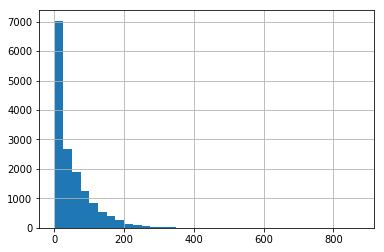

In [11]:
pt=product_owner_w_lastUserBehav2['pi_mean'].hist(bins=35)
#pt.set_xlim([0,200])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000129A3A8C8D0>,
      dtype=object)

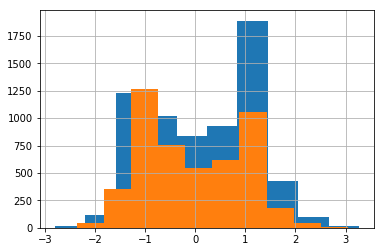

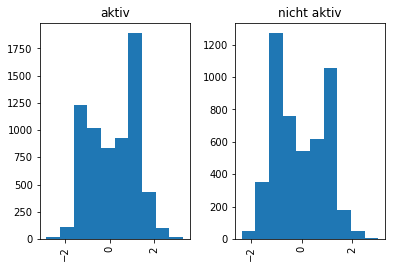

In [12]:
product_owner_w_lastUserBehav2.groupby('Vertragsstatus')['pi_lastMonth_z-score'].hist()
product_owner_w_lastUserBehav2[['pi_lastMonth_z-score','Vertragsstatus']].hist(by = 'Vertragsstatus')

In [13]:
# new column: Vertragslaenge
product_owner_w_lastUserBehav2['Vertragslaenge'] = (product_owner_w_lastUserBehav2['VE_Tag'] - product_owner_w_lastUserBehav2['VB_Tag']) / np.timedelta64(1,'D')
# Schnorrer = Vertragslaenge 2 Monate, Kuendigungsgrund = 'Nichtzahler'
product_owner_w_lastUserBehav_ohneSchnorrer = product_owner_w_lastUserBehav2[
    -((product_owner_w_lastUserBehav2['Vertragslaenge'] <=61) & 
        (product_owner_w_lastUserBehav2['Kuendigungsgrund']=='Nichtzahler '))]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000129A24666D8>,
      dtype=object)

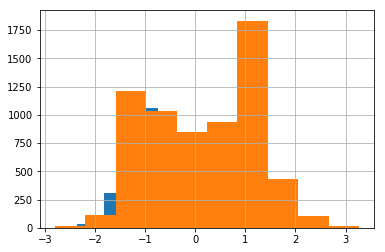

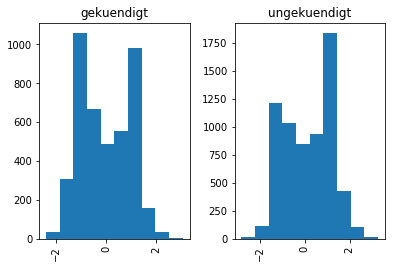

In [26]:
product_owner_w_lastUserBehav_ohneSchnorrer.groupby('Kuendigungsstatus')['pi_lastMonth_z-score'].hist()
product_owner_w_lastUserBehav_ohneSchnorrer[['pi_lastMonth_z-score','Kuendigungsstatus']].hist(by = 'Kuendigungsstatus')

In [23]:
low_Z_Score = product_owner_w_lastUserBehav_ohneSchnorrer.loc[\
    (product_owner_w_lastUserBehav_ohneSchnorrer['pi_lastMonth_z-score']<-0.5)]

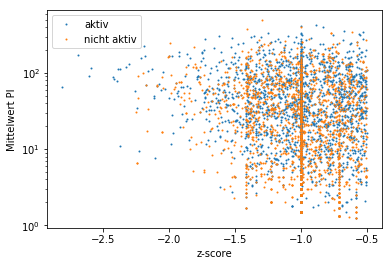

In [35]:
groups = low_Z_Score.groupby('Vertragsstatus')

fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['pi_lastMonth_z-score'], group['pi_mean'], marker='o', linestyle='', ms=1, label=name)
ax.legend()
ax.set_xlabel("z-score")
ax.set_ylabel("Mittelwert PI")
ax.set_yscale('log')

plt.show()

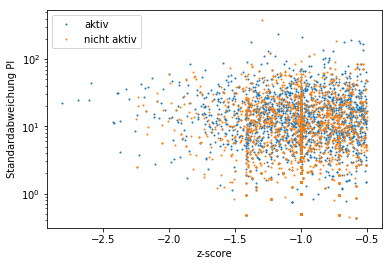

In [32]:
groups = low_Z_Score.groupby('Vertragsstatus')

fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['pi_lastMonth_z-score'], group['pi_std'], marker='o', linestyle='', ms=1, label=name)
ax.legend()
ax.set_xlabel("z-score")
ax.set_ylabel("Standardabweichung PI")
ax.set_yscale('log')

plt.show()

In [37]:
low_Z_Score[(low_Z_Score['pi_lastMonth_z-score']==-1)]

,1_pi,1_pi_per_v,1_v,2016/12,2016/12.1,2017/01,2017/01.1,2017/02,2017/02.1,2017/03,...,Vertragsform,Vertragsphase,Vertragsstatus,pi_lastMonth_z-score,pi_mean,pi_std,v_lastMonth_z-score,v_mean,v_std,Vertragslaenge
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,nicht aktiv,-1.0,2.5,1.5,-1.00000,9.5000,6.50000,122.0
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,aktiv,-1.0,7.5,3.5,-1.00000,21.0000,17.00000,88.0
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,nicht aktiv,-1.0,14.5,12.5,-1.00000,46.5000,44.50000,58.0
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,24.0,14.0,...,NOP,Vollabo,nicht aktiv,-1.0,15.5,1.5,1.00000,25.5000,1.50000,89.0
151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,aktiv,-1.0,2.5,0.5,-1.00000,13.0000,10.00000,58.0
549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,aktiv,-1.0,44.5,12.5,-1.00000,98.5000,32.50000,58.0
671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,nicht aktiv,-1.0,1.5,0.5,-1.36201,12.0000,5.87367,122.0
738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,nicht aktiv,-1.0,36.0,26.0,1.00000,96.7665,95.23350,60.0
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,aktiv,-1.0,239.5,14.5,-1.00000,561.5000,35.50000,58.0
868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NOP,Vollabo,nicht aktiv,-1.0,28.5,4.5,-1.00000,74.5000,22.50000,36.0
